In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_test_result=pd.read_csv("gender_submission.csv")

In [2]:
def transOnehot(dataSet,index):
    length = len(dataSet)
    max = dataSet[index].max().astype(int)
    result = []
    for number in dataSet[index]:
        zero = np.zeros(max + 1)
        zero[int(number)] = 1
        result.append(zero.tolist())
    return np.array(result)

In [3]:
def deal_data(dataSet,change_survived):
    """处理数据"""
    #将名字中的Mr,Mrs,Miss抽出来
    dataSet['Title'] = dataSet['Name'].apply(lambda x:x.split(',')[1]).apply(lambda x:x.split()[0])
    dataSet.loc[~(df_train['Title'].isin(['Master.','Mrs.','Miss.','Master.'])),'Title_Val'] = 4
    dataSet.loc[(df_train['Title'].isin(['Mr.'])),'Title_Val'] = 0
    dataSet.loc[(df_train['Title'].isin(['Mrs.'])),'Title_Val'] = 1
    dataSet.loc[(df_train['Title'].isin(['Miss.'])),'Title_Val'] = 2
    dataSet.loc[(df_train['Title'].isin(['Master.'])),'Title_Val'] = 3
    #转化成onehot类型   
#     title_val = transOnehot(dataSet,'Title_Val')
#     dataSet['Title_Val_0']  = title_val[:,0]
#     dataSet['Title_Val_1']  = title_val[:,1]
#     dataSet['Title_Val_2']  = title_val[:,2]
#     dataSet['Title_Val_3']  = title_val[:,3]
#     dataSet['Title_Val_4']  = title_val[:,4]
    
    #将性别转化成离散值Sex_Val{'male':0,'female':1}
    sexes = dataSet['Sex'].unique()
    genders_mapping_one = dict(zip(sexes, range(0, len(sexes) + 1)))
    dataSet['Sex_Val'] = dataSet['Sex'].map(genders_mapping_one).astype(int)
    
    #将SibSp,Parch 转化成一个离散值Family
    dataSet['FamilySize'] = dataSet['SibSp'] + dataSet['Parch']
    #将Fare归一化
    dataSet.loc[(dataSet['Fare'].isnull()),'Fare'] = dataSet['Fare'].median()
    maxFare = dataSet['Fare'].max()
    minFare = dataSet['Fare'].min()
    dit = maxFare - minFare
    dataSet['FareNormal'] = dataSet['Fare']/dit
    
    #将Cabin的有无当成一个特征Cabin_Val{'unexist':0,'exist':1}
    dataSet.loc[ (dataSet.Cabin.notnull()), 'Cabin_Val' ] = 1
    dataSet.loc[ (dataSet.Cabin.isnull()), 'Cabin_Val' ] = 0
    
     #将Embarked转化成数字Embarked_Val={'S':0,'C':1,'Q':2}
    embarked_locs = dataSet['Embarked'].unique()
    embarked_locs_mapping = dict(zip(embarked_locs,range(0, len(embarked_locs) + 1)))
    dataSet['Embarked_Val'] = dataSet['Embarked'].map(embarked_locs_mapping).astype(int)
    #用众数替换目的地的缺失值
    if len(dataSet[dataSet['Embarked'].isnull()] > 0):
        dataSet.replace({'Embarked_Val' : 
                   { embarked_locs_mapping[np.nan] : embarked_locs_mapping['S']}
               },inplace=True)
    #转化成onehot类型    
#     embarked_val = transOnehot(dataSet,'Embarked_Val')
#     dataSet['Embarked_Val_0']  = embarked_val[:,0]
#     dataSet['Embarked_Val_1']  = embarked_val[:,1]
#     dataSet['Embarked_Val_2']  = embarked_val[:,2]
    
    
    #用众数(考虑性别和等级）替换缺失的Age值
    dataSet['AgeFill'] = dataSet['Age']
    dataSet['AgeFill'] = dataSet['AgeFill'] \
                        .groupby([dataSet['Sex_Val'], dataSet['Pclass']]) \
                        .apply(lambda x: x.fillna(x.median()))
    dataSet['AgeFill'] = dataSet['AgeFill'] - dataSet['AgeFill'].min()
    dit = dataSet['AgeFill'].max() - dataSet['AgeFill'].min()
    dataSet['AgeFill'] = dataSet['AgeFill']/dit
    
    #剔除用不到的特征
#     dataSet = dataSet.drop(['Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Cabin','Title','PassengerId','Title_Val','Embarked_Val'], axis=1)
    dataSet = dataSet.drop(['Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Cabin','Title','PassengerId'], axis=1)
    if change_survived:
        dataSet['Survived_End'] = dataSet['Survived']
        dataSet = dataSet.drop(['Survived'], axis=1)
        
#     dataSet_modify = dataSet.values
    #对数据进行归一化
    dataSet_modify = dataSet.values
    return dataSet_modify

In [4]:
trainSet= deal_data(df_train,change_survived=True)    #shape = (?,9)
testSet = deal_data(df_test,change_survived=False)    #shape = (?,8)

In [5]:
trainSet.shape

(891, 9)

In [6]:
#留出法
def hold_out(dataSet,train_size):
    """
    dataSet:数据集
    train_size:留出法中训练集所占得比例
    """
    totalLen = dataSet.shape[0]
    len = int(totalLen * train_size)
    index = range(totalLen)
    index_1 = np.random.choice(index,len,replace=False)     #训练集的下标
    index_2 = np.delete(index,index_1)                      #测试集的下标
    train = dataSet[index_1]
    test = dataSet[index_2]
    return train,test

In [7]:
#交叉验证法
def cross_valid(dataSet,k=10):
    """
    dataSet:数据集
    k：k次交叉验证的数目
    return : datasets：shape(k,num,feature)  list类型
    """
    datasets =[]
    num = int(dataSet.shape[0]/k)
    start = 0
    end = num
    for i in range(k):
        datasets.append(dataSet[start:end,:].tolist())
        start += num
        end += num
    return datasets

In [8]:
#自助法
def bootstrapping(dataSet):
    m = dataSet.shape[0]
    index1 = []
    index2 = []
    for i in range(m):
        index1.append(np.random.randint(m))
    index2 = np.delete(range(m),index1)
    train = dataSet[index1]
    test = dataSet[index2]
    return train,test

In [9]:
def sigmoid(X):
    return 1/(1 + np.exp(-X))

In [10]:
def grad(X,Y,learning_rate = 0.01,iter_size = 50):
    """
    X:输入数据，shape：（样本数目，特征数目）
    Y:标签，shape：（样本数目，1）
    weithts：权重，shape：（特征数目，1）
    learning_rate:学习率
    """
    Y = Y.reshape([-1,1])
    n = X.shape[1] 
    weights = np.ones([n,1])
    for i in range(iter_size):
        A = np.dot(X ,weights)
        G = sigmoid(A) - Y
        weights = weights - learning_rate * np.dot(X.T , G)
    return weights

In [11]:
def logistic(dataSet,learning_rate = 0.01,iter_size = 50):
    X = dataSet[:,:-1]
    Y = dataSet[:,-1]
    weights = grad(X,Y,learning_rate,iter_size)
    return weights

In [12]:
def predict(dataSet,testSet,learning_rate,iter_size,node = 0.5):
    weights = logistic(dataSet,learning_rate,iter_size)
    predicts = sigmoid(np.dot(testSet,weights)).reshape(-1)
    for i in range(len(predicts)):
        if(predicts[i] > node):
            predicts[i] = 1
        else:
            predicts[i] = 0
    return predicts.astype(int)

In [13]:
def information(predicts,y):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(predicts)):
        if(predicts[i] == 1):
            if(y[i] == 1):
                TP += 1
            else:
                FP += 1
        else:
            if(y[i] == 1):
                FN += 1
            else:
                TN += 1
    return TP,FP,TN,FN

In [14]:
#准确率
def getAccuracy(predicts,y):
    return(predicts == y).sum()/len(y)

In [15]:
#精确率
def getPrecision(predicts,y):
    TP,FP,TN,FN = information(predicts,y)
    precision = TP/(TP + FP)
    return precision

In [16]:
#召回率
def getRecall(predicts,y):
    TP,FP,TN,FN = information(predicts,y)
    recall = TP/(TP + FN)
    return recall

In [17]:
def getF1Score(predicts,y):
    predicision = getPrecision(predicts,y)
    recall = getRecall(predicts,y)
    F1Score =2 * predicision * recall/(predicision + recall)
    return F1Score

In [18]:
def getRocAndAuc(dataSet,testSet,learning_rate,iter_size):
    testX = testSet[:,:-1]
    testY = testSet[:,-1]
    weights = logistic(dataSet,learning_rate,iter_size)
    predicts = sigmoid(np.dot(testX,weights)).reshape(-1)
    unique = set(predicts)
    x = []
    y = []
    for predict in predicts:
        z = []
        for i in range(len(predicts)):
            if(predicts[i] > predict):
                z.append(1)
            else:
                z.append(0)
        TP,FP,TN,FN = information(z,testY)
        y.append(TP/(TP + FN))
        x.append(FP/(TN + FP))
    
    x = np.array(x)
    y = np.array(y)
    index = np.argsort(x)
    x = x[index]
    y = y[index]
    AUC = 0
    for i in range(len(x) - 1):
        AUC += (x[i+1] - x[i]) * (y[i] + y[i+1]) /2
    plt.plot(x,y)
    plt.xlabel("假正例率",fontproperties = 'SimHei',fontsize = 15)
    plt.ylabel("真正例率",fontproperties = 'SimHei',fontsize = 15)
    plt.title("ROC曲线",fontproperties = 'SimHei',fontsize = 15)
    plt.show()
    return AUC

In [19]:
train,test = bootstrapping(trainSet)

In [20]:
testX = test[:,:-1]
testY = test[:,-1]

In [52]:
predicts = predict(train,testX,0.001,100,0.5)

In [53]:
accuracy = getAccuracy(predicts,testY)
precision = getPrecision(predicts,testY)
recall = getRecall(predicts,testY)
F1Score = getF1Score(predicts,testY)
print("F1Score",F1Score)
print("accuracy:",accuracy)
print("precison:",precision)
print("recall:",recall)

F1Score 0.719298245614035
accuracy: 0.8054711246200608
precison: 0.7522935779816514
recall: 0.6890756302521008


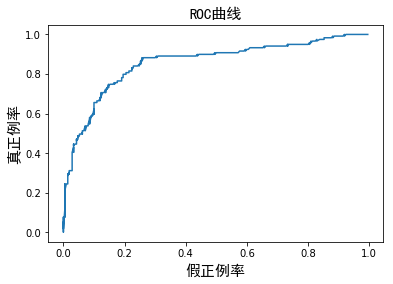

In [54]:
AUC = getRocAndAuc(train,test,0.001,200)

In [55]:
AUC

0.8520208083233292

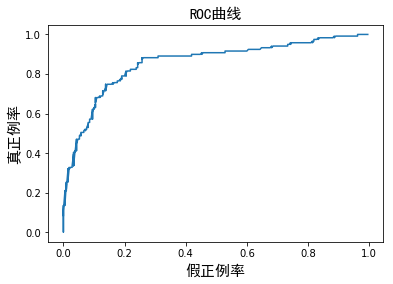

In [56]:
AUC = getRocAndAuc(train,test,0.001,100)

In [51]:
AUC

0.8526810724289714

In [57]:
result = predict(trainSet,testSet,0.001,100,0.5)

In [58]:
df_test['Survived'] = result
df_test[['PassengerId','Survived']].to_csv('results-rf2.csv',index=False)